In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import sys
sys.path.insert(0, 'FCMeans')
from fcmeans import spfcmeans

In [2]:
import json
raw=[]
f=open("Data/Berita/Debat-5.json",mode='r',encoding='utf-8',errors='ignore');f1=f.readlines();f.close()
for i,t in enumerate(f1):
    raw.append(json.loads(t.strip()))

selected=[]
for i in raw:
    try:selected.append(re.sub(' +',' ',re.sub('\n',' ',i['extended_tweet']['full_text'])))
    except:selected.append(re.sub(' +',' ',re.sub('\n',' ',i['text'])))
dataset=pd.DataFrame(selected,columns=["text"])

In [3]:
# EXPLORE the data
## Show the first 5 data
dataset.head()

,text
0,RT @ASapardan: Jum'atan gak jelas Ngaji gak be...
1,Masa tenang dimulai dengan debat capres cawapr...
2,RT @MichelAdamNew: Ustadz Basalamah PILIH PRAB...
3,Manusia sampah
4,RT @PantunJ2P: @jokowi #JokowiDILANjutkanLagi ...


In [4]:
## Cleaning
stopwords = pd.read_csv("Data/Stopwords/stopwords_id.csv")
stopwords = np.append(stopwords, "rt")

def clean_text(tweet):
    
    # Convert to lower case
    tweet = tweet.strip().lower()
    
    # Clean www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    # Clean @username
    tweet = re.sub('@[^\s]+','',tweet)
    # Clean # from #word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    # Replace three or more into two alphabet occurrences
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    tweet = pattern.sub(r"\1\1", tweet)
    # Strip digit from word
    tweet = re.sub("[0-9]","", tweet)
    # Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    # Remove stop and short words
    tokenizer = re.compile( r"(?u)\b\w\w+\b" )
    tokens = []
    for tok in tokenizer.findall( tweet ):
        if (tok in stopwords or len(tok) < 2):
            continue
        else:
            tokens.append(tok)

    tweet = " ".join(tokens)
    return tweet.strip()

dataset['text'] = dataset['text'].astype(str)
dataset['text'] = dataset['text'].map(lambda x: clean_text(x))
dataset['text'] = dataset[dataset['text'].apply(lambda x: len(x.split()) >=3)]
dataset.head()

,text
0,jum atan gak ngaji gak becus wudhu blepotan sh...
1,tenang debat capres cawapres jiniyes
2,ustadz basalamah pilih prabowo sandi merapat m...
3,NaN
4,jokowidilanjutkanlagi perginya diantar berlaya...


In [5]:
dataset = dataset.dropna()

In [6]:
# MODEL the data
## Preprocessing - Tokenization, Weighting, Vectorization
vectorizer = TfidfVectorizer(min_df=2,max_df=0.95)
data = vectorizer.fit_transform(dataset['text'])
feature_names = vectorizer.get_feature_names()
#print(feature_names)
#print(data.shape)

In [7]:
## Dimension reduction
svd = TruncatedSVD(n_components = 5)
svd_data = svd.fit_transform(data)

In [8]:
print(svd_data)

[[ 0.00333621  0.00925986  0.01064319  0.01322151 -0.00138343]
 [ 0.01281666  0.08709831  0.04396044  0.21766513 -0.07384531]
 [ 0.01554769  0.09480731  0.17534896 -0.03663183 -0.01121882]
 ...
 [ 0.00422449  0.01330197  0.0118267   0.02702029 -0.00644533]
 [ 0.00862906  0.03615092  0.06025851  0.00739883  0.00778625]
 [ 0.01109747  0.04578479  0.07464025  0.01828423  0.00193368]]


In [106]:
import gensim
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Model selection
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.wv.vocab:
                if pair[1] in w2v_model.wv.vocab:
                    pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
                else:
                    pair_scores.append(0)
            else:
                pair_scores.append(0)
                
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

### Loading model Word2Vec
w2v_model = gensim.models.Word2Vec.load("Data/word2vec/w2v-model.bin")

### Determining coherence value
n_top_words = 10
num_topics = []
coherences = []
coherences_mean = []
np.random.shuffle(svd_data)
for n_topics in range(2,21,2):
    print("The number of topics is " + str(n_topics))
    
    coherence_sim = []
    for i in range(1,6):
        print("The simulation " + str(i))
        
        m = 2
        
        #membership (u) calculation in the lower space
        cntr, u = spfcmeans(svd_data, n_topics, m, error=0.005, maxiter=1000, chunk=20)
        
        #centroid (cntr) calculation in the original space
        cntr = svd.inverse_transform(cntr)
        
        #coherence calculation
        coherence_topic = []
        for topic_idx, topic in enumerate(cntr):
            top_terms = []
            top_terms.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
            coherence_topic.append(calculate_coherence(w2v_model, top_terms))
            print(top_terms)
        print(coherence_topic)
        coherence_sim.append(sum(coherence_topic) / len(coherence_topic))
    
    num_topics.append(n_topics)
    coherences.append(coherence_sim)
    coherences_mean.append(sum(coherence_sim) / len(coherence_sim))
    
### Determining best number of topics
cmax = max(coherences_mean)
best_num_topics = num_topics[coherences_mean.index(cmax)]
print("The number of topics is %d with coherence of %f" % (best_num_topics, cmax))

The number of topics is 2
The simulation 1
[['debat', 'malam', 'giveaway', 'jokowi', 'semangatin', 'prabowo', 'jokowimenangtotaldebat', 'reply', 'saudara', 'nonton']]
[['debat', 'prabowo', 'sandi', 'gym', 'aagympilihprabowo', 'jokowi', 'aa', 'bismillah', 'malam', 'jokowimenangtotaldebat']]
[0.2745075673501135, 0.265390591733649]
The simulation 2
[['debat', 'prabowo', 'sandi', 'gym', 'aagympilihprabowo', 'jokowi', 'aa', 'bismillah', 'malam', 'jokowimenangtotaldebat']]
[['debat', 'malam', 'giveaway', 'jokowi', 'semangatin', 'prabowo', 'jokowimenangtotaldebat', 'reply', 'saudara', 'nonton']]
[0.265390591733649, 0.2745075673501135]
The simulation 3
[['debat', 'prabowo', 'sandi', 'gym', 'aagympilihprabowo', 'jokowi', 'aa', 'bismillah', 'malam', 'jokowimenangtotaldebat']]
[['debat', 'malam', 'giveaway', 'jokowi', 'semangatin', 'prabowo', 'jokowimenangtotaldebat', 'reply', 'saudara', 'nonton']]
[0.265390591733649, 0.2745075673501135]
The simulation 4
[['debat', 'prabowo', 'sandi', 'gym', 'aag

[['prabowo', 'sandi', 'gym', 'aa', 'bismillah', 'aagympilihprabowo', 'dukung', 'milih', 'resmi', 'jokowi']]
[['debat', 'prabowo', 'jokowi', 'malam', 'sandi', 'giveaway', 'jokowimenangtotaldebat', 'aagympilihprabowo', 'gym', 'semangatin']]
[['debat', 'malam', 'giveaway', 'semangatin', 'reply', 'nonton', 'jokowimenangtotaldebat', 'jokowi', 'jam', 'capres']]
[['saudara', 'memeluk', 'betapa', 'pelukan', 'cinta', 'nama', 'indonesia', 'jokowi', 'yg', 'jokowimenangtotaldebat']]
[['debat', 'malam', 'giveaway', 'jokowi', 'prabowo', 'jokowimenangtotaldebat', 'semangatin', 'reply', 'sandi', 'nonton']]
[['debat', 'jokowi', 'prabowo', 'malam', 'giveaway', 'jokowimenangtotaldebat', 'sandi', 'gbk', 'aagympilihprabowo', 'ulama']]
[['prabowo', 'sandi', 'gym', 'aa', 'bismillah', 'aagympilihprabowo', 'milih', 'dukung', 'resmi', 'memilih']]
[['polling', 'trending', 'dijagat', 'topic', 'tagar', 'twitter', 'yuk', 'menggema', 'dil', 'dahlaniskanpilihprabowo']]
[0.2827745633762152, 0.2834839565231839, 0.31461

[['prabowo', 'sandi', 'gym', 'aa', 'bismillah', 'aagympilihprabowo', 'dukung', 'milih', 'resmi', 'memilih']]
[['debat', 'malam', 'prabowo', 'jokowi', 'giveaway', 'sandi', 'jokowimenangtotaldebat', 'semangatin', 'aagympilihprabowo', 'reply']]
[['debat', 'malam', 'giveaway', 'semangatin', 'reply', 'nonton', 'jokowimenangtotaldebat', 'jokowi', 'jam', 'pilpres']]
[['debat', 'malam', 'giveaway', 'jokowi', 'semangatin', 'jokowimenangtotaldebat', 'reply', 'prabowo', 'nonton', 'sandi']]
[['prabowo', 'sandi', 'gym', 'aa', 'bismillah', 'aagympilihprabowo', 'milih', 'dukung', 'resmi', 'memilih']]
[['polling', 'trending', 'dijagat', 'topic', 'tagar', 'twitter', 'yuk', 'menggema', 'dil', 'dahlaniskanpilihprabowo']]
[['saudara', 'memeluk', 'betapa', 'pelukan', 'cinta', 'nama', 'indonesia', 'jokowi', 'yg', 'jokowimenangtotaldebat']]
[['mbah', 'tasbih', 'luthfi', 'ulama', 'maemun', 'habib', 'sedunia', 'sufi', 'ketua', 'layar']]
[['debat', 'malam', 'giveaway', 'semangatin', 'reply', 'nonton', 'jokowime

[['prabowo', 'sandi', 'gym', 'aa', 'bismillah', 'aagympilihprabowo', 'dukung', 'milih', 'resmi', 'memilih']]
[['debat', 'malam', 'giveaway', 'jokowi', 'prabowo', 'jokowimenangtotaldebat', 'semangatin', 'reply', 'sandi', 'nonton']]
[['debat', 'malam', 'jokowi', 'giveaway', 'prabowo', 'jokowimenangtotaldebat', 'semangatin', 'sandi', 'reply', 'aagympilihprabowo']]
[['debat', 'prabowo', 'malam', 'jokowi', 'giveaway', 'sandi', 'jokowimenangtotaldebat', 'aagympilihprabowo', 'semangatin', 'gym']]
[['prabowo', 'sandi', 'gym', 'aa', 'bismillah', 'aagympilihprabowo', 'milih', 'dukung', 'resmi', 'memilih']]
[['mbah', 'tasbih', 'luthfi', 'ulama', 'maemun', 'habib', 'sedunia', 'sufi', 'ketua', 'layar']]
[['saudara', 'memeluk', 'betapa', 'pelukan', 'cinta', 'nama', 'indonesia', 'jokowi', 'yg', 'jokowimenangtotaldebat']]
[['debat', 'malam', 'giveaway', 'semangatin', 'reply', 'nonton', 'jokowimenangtotaldebat', 'jokowi', 'jam', 'capres']]
[['prabowo', 'sandi', 'gym', 'aa', 'bismillah', 'aagympilihprab

[['debat', 'prabowo', 'malam', 'jokowi', 'giveaway', 'sandi', 'jokowimenangtotaldebat', 'aagympilihprabowo', 'semangatin', 'gym']]
[['debat', 'malam', 'giveaway', 'semangatin', 'reply', 'nonton', 'jokowimenangtotaldebat', 'jokowi', 'jam', 'capres']]
[['mbah', 'tasbih', 'luthfi', 'ulama', 'maemun', 'habib', 'sedunia', 'sufi', 'ketua', 'layar']]
[['polling', 'trending', 'dijagat', 'topic', 'tagar', 'twitter', 'yuk', 'menggema', 'dil', 'dahlaniskanpilihprabowo']]
[['mbah', 'tasbih', 'luthfi', 'ulama', 'maemun', 'habib', 'sedunia', 'sufi', 'ketua', 'layar']]
[['prabowo', 'sandi', 'gym', 'aa', 'bismillah', 'aagympilihprabowo', 'dukung', 'milih', 'resmi', 'memilih']]
[['prabowo', 'sandi', 'gym', 'aa', 'bismillah', 'aagympilihprabowo', 'milih', 'dukung', 'resmi', 'memilih']]
[['polling', 'trending', 'dijagat', 'tagar', 'topic', 'yuk', 'twitter', 'menggema', 'dil', 'dahlaniskanpilihprabowo']]
[['debat', 'malam', 'giveaway', 'jokowi', 'jokowimenangtotaldebat', 'prabowo', 'semangatin', 'reply', 

[['mbah', 'tasbih', 'luthfi', 'ulama', 'maemun', 'habib', 'sedunia', 'sufi', 'ketua', 'layar']]
[['debat', 'malam', 'giveaway', 'semangatin', 'reply', 'nonton', 'jokowimenangtotaldebat', 'jokowi', 'jam', 'capres']]
[['debat', 'malam', 'giveaway', 'jokowi', 'prabowo', 'jokowimenangtotaldebat', 'semangatin', 'reply', 'sandi', 'nonton']]
[['prabowo', 'sandi', 'gym', 'aa', 'bismillah', 'aagympilihprabowo', 'dukung', 'debat', 'milih', 'resmi']]
[['polling', 'trending', 'dijagat', 'topic', 'tagar', 'twitter', 'yuk', 'menggema', 'dil', 'dahlaniskanpilihprabowo']]
[['debat', 'malam', 'giveaway', 'pilpres', 'semangatin', 'yuk', 'reply', 'polling', 'jokowi', 'nonton']]
[['mbah', 'tasbih', 'luthfi', 'ulama', 'maemun', 'habib', 'sedunia', 'sufi', 'ketua', 'layar']]
[['prabowo', 'sandi', 'gym', 'aa', 'bismillah', 'aagympilihprabowo', 'milih', 'dukung', 'resmi', 'memilih']]
[['prabowo', 'sandi', 'gym', 'aa', 'bismillah', 'aagympilihprabowo', 'dukung', 'milih', 'resmi', 'memilih']]
[['prabowo', 'sand

[['debat', 'malam', 'giveaway', 'jokowi', 'semangatin', 'jokowimenangtotaldebat', 'reply', 'prabowo', 'nonton', 'sandi']]
[['prabowo', 'sandi', 'gym', 'aa', 'bismillah', 'aagympilihprabowo', 'debat', 'dukung', 'milih', 'resmi']]
[['saudara', 'memeluk', 'betapa', 'pelukan', 'cinta', 'nama', 'indonesia', 'jokowi', 'yg', 'jokowimenangtotaldebat']]
[['prabowo', 'sandi', 'gym', 'aa', 'bismillah', 'aagympilihprabowo', 'dukung', 'milih', 'resmi', 'memilih']]
[['debat', 'malam', 'giveaway', 'semangatin', 'reply', 'nonton', 'jokowimenangtotaldebat', 'jokowi', 'jam', 'capres']]
[['prabowo', 'sandi', 'gym', 'aa', 'bismillah', 'aagympilihprabowo', 'milih', 'dukung', 'resmi', 'memilih']]
[['mbah', 'tasbih', 'luthfi', 'ulama', 'maemun', 'habib', 'sedunia', 'sufi', 'ketua', 'layar']]
[['debat', 'giveaway', 'malam', 'semangatin', 'reply', 'nonton', 'jokowimenangtotaldebat', 'jokowi', 'jam', 'capres']]
[['debat', 'malam', 'giveaway', 'semangatin', 'reply', 'nonton', 'jokowimenangtotaldebat', 'jokowi', 

[['debat', 'prabowo', 'malam', 'jokowi', 'giveaway', 'sandi', 'jokowimenangtotaldebat', 'aagympilihprabowo', 'gym', 'semangatin']]
[['debat', 'malam', 'giveaway', 'semangatin', 'reply', 'nonton', 'jokowimenangtotaldebat', 'jokowi', 'jam', 'capres']]
[['debat', 'giveaway', 'malam', 'semangatin', 'reply', 'nonton', 'jokowimenangtotaldebat', 'jokowi', 'jam', 'capres']]
[['debat', 'malam', 'giveaway', 'semangatin', 'reply', 'nonton', 'jokowi', 'jokowimenangtotaldebat', 'pilpres', 'yuk']]
[['debat', 'malam', 'giveaway', 'jokowi', 'semangatin', 'jokowimenangtotaldebat', 'reply', 'nonton', 'prabowo', 'gbk']]
[['mbah', 'tasbih', 'luthfi', 'ulama', 'maemun', 'habib', 'sedunia', 'sufi', 'ketua', 'layar']]
[['prabowo', 'sandi', 'gym', 'aa', 'bismillah', 'aagympilihprabowo', 'debat', 'dukung', 'milih', 'resmi']]
[['prabowo', 'sandi', 'gym', 'aa', 'bismillah', 'aagympilihprabowo', 'dukung', 'milih', 'resmi', 'memilih']]
[['prabowo', 'sandi', 'gym', 'aa', 'bismillah', 'aagympilihprabowo', 'milih', '

Text(0, 0.5, 'Coherence')

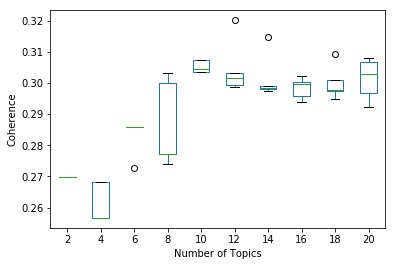

In [107]:
## Visualization
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
boxplot = df.boxplot(grid=False)
boxplot.set_xlabel("Number of Topics")
boxplot.set_ylabel("Coherence")

In [109]:
## Save to Excel
df.to_excel("Data/results/beritaSPFCM_C20_R5.xlsx")